In [1]:
from IPython.display import display,HTML
import warnings
warnings.filterwarnings(action='ignore')

#데이터 전처리
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
#기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score,recall_score,precision_score,mean_squared_error,confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from datetime import datetime
from io import StringIO
matplotlib.rcParams['axes.unicode_minus'] = False
#한글 폰트 설정
plt.rc('font',family ='Malgun Gothic')
import matplotlib.dates as mdates


from changefinder import ChangeFinder


c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\anaconda3\lib\sit

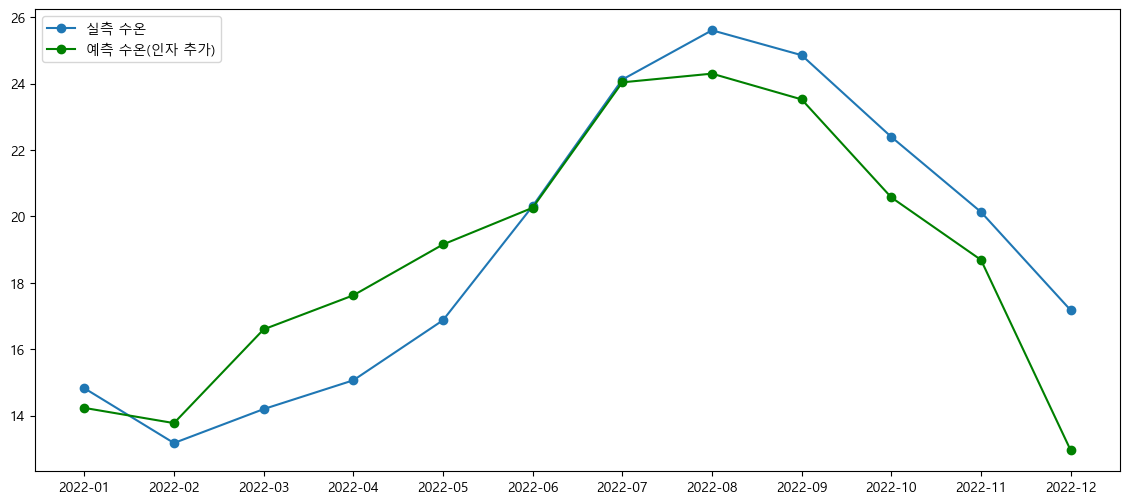

RMSE: 7.769166986792072


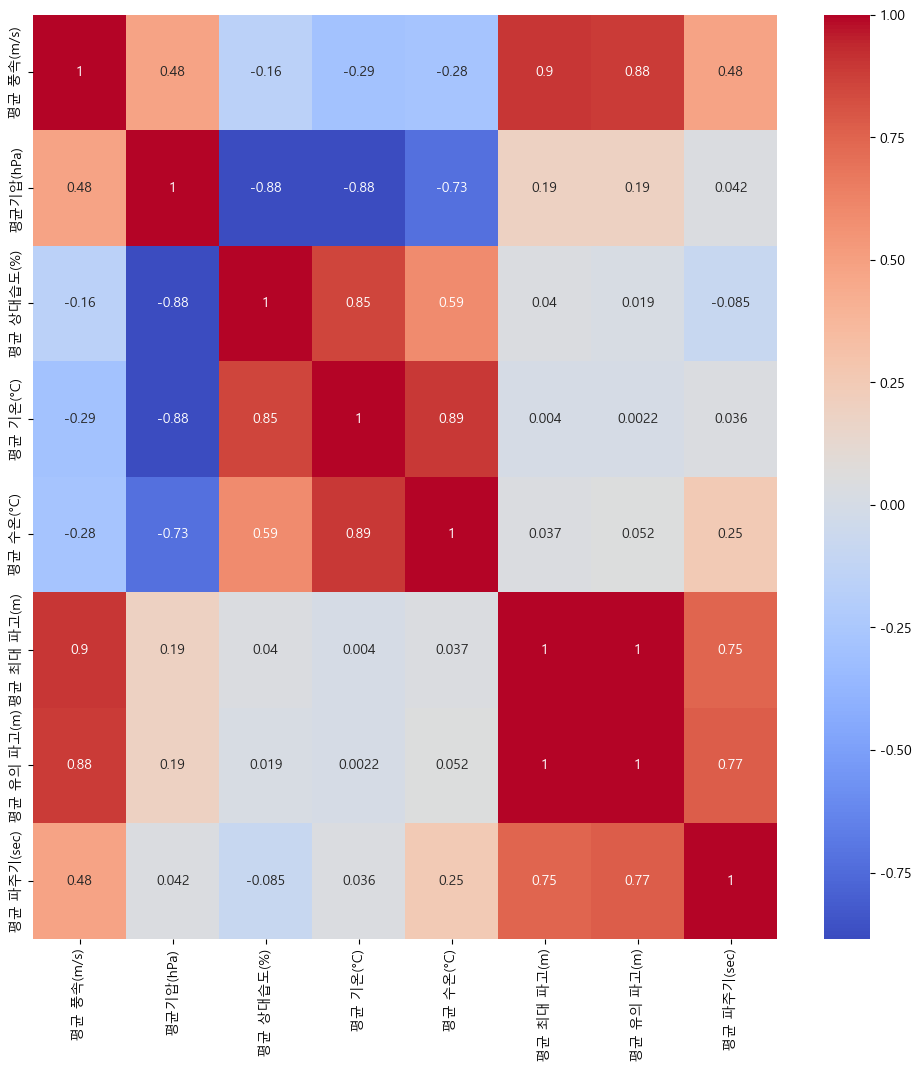

In [2]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('거제도.csv', parse_dates=True, encoding='cp949')
data=data.set_index('일시') # 일시를 인덱스로
data.index = pd.to_datetime(data.index)
# print('data first',data)
# 월 평균 계산
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('M').mean()
data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환

data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m')

# 데이터프레임 열 합치기
# data = pd.concat([data, data1], axis=1)
# print('data:',data)
data = data.reset_index()  # 인덱스를 열로 변환
data.to_csv('data/data어획_test.csv', index=False)
data = data.set_index('일시')  # 다시 인덱스로 설정

# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
# print('exog:',exog)

# 시계열 모델을 학습합니다.
model = SARIMAX(data['평균 수온(°C)'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 12), exog=exog)
results = model.fit(disp=False)

# 특정 기간의 'start_date'과 'end_date' 열 선택
start_date = '2022-01'
end_date = '2022-12'
data = data.loc[start_date:end_date]
# print('data2:',data)

# 예측 기간을 설정합니다.
validate_steps = 12

# 예측 결과와 신뢰 구간을 얻습니다.
validate2 = results.get_forecast(steps=validate_steps, exog=exog.loc[start_date:end_date])
validate_conf_int = validate2.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

validate_index2 = pd.period_range(start='2022-01-19', periods=validate_steps, freq='M')

validate_index_timestamp = validate_index2.to_timestamp()  # PeriodIndex를 Timestamp로 변환
validate2.predicted_mean.index = validate_index2
validate_conf_int.index = validate_index2

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['평균 수온(°C)'], label='실측 수온', marker='o', linestyle='-')
plt.plot(validate_index2.strftime('%Y-%m'), validate2.predicted_mean, label='예측 수온(인자 추가)', color='g', marker='o', linestyle='-')

# 예측값 만들기
# 특정 기간의 'start_date'과 'end_date' 열 선택
# start_date = '2024-01'
# end_date = '2050-12'

# forecast_steps = 324
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:]) # 이거 만들어야 됨
forecast_conf_int = forecast.conf_int()
forecast_index = pd.period_range(start='2022-01-19', periods=forecast_steps, freq='m')

forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 예측 만들기, 범위 지정
# plt.plot(forecast_index.strftime('%Y-%m'), forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
# plt.fill_between(forecast_index.strftime('%Y-%m'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

# print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['평균 수온(°C)'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


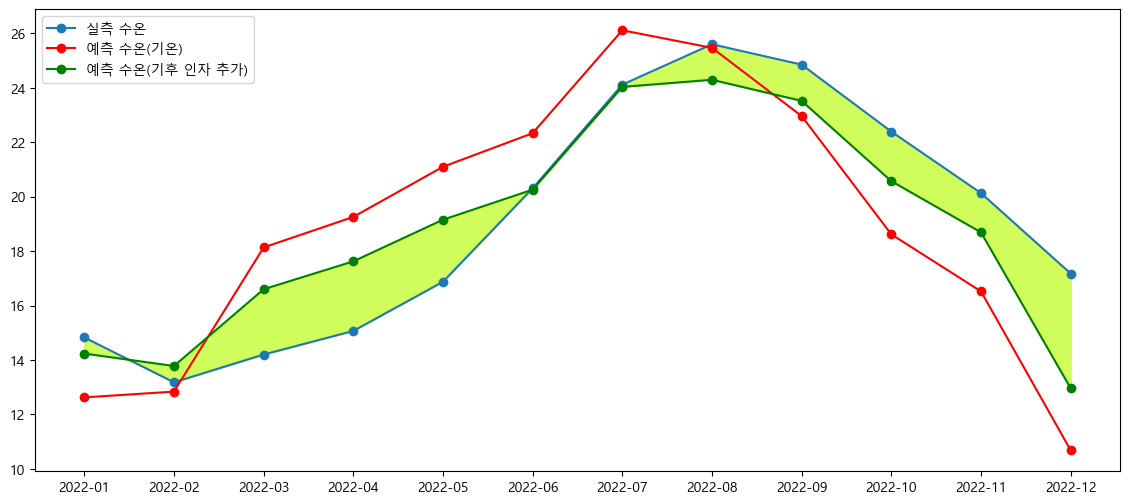

In [3]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
data=data.set_index('일시') # 일시를 인덱스로
data.index = pd.to_datetime(data.index)
# 월 평균 계산
data = data[['평균 기온(°C)','평균 수온(°C)']].resample('M').mean()
data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환

data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m')

data = data.reset_index()  # 인덱스를 열로 변환
data.to_csv('data/data어획_test.csv', index=False)
data = data.set_index('일시')  # 다시 인덱스로 설정

# exog를 다시 정의합니다.
exog = data[['평균 기온(°C)']]
# 시계열 모델을 학습합니다.
model = SARIMAX(data['평균 수온(°C)'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 12), exog=exog)
results = model.fit(disp=False)

# 특정 기간의 'start_date'과 'end_date' 열 선택
start_date = '2022-01'
end_date = '2022-12'
data = data.loc[start_date:end_date]


# 예측 기간을 설정합니다.
validate_steps = 12

# 예측 결과와 신뢰 구간을 얻습니다.
validate = results.get_forecast(steps=validate_steps, exog=exog.loc[start_date:end_date])
validate_conf_int = validate.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

validate_index = pd.period_range(start='2022-01-19', periods=validate_steps, freq='M')

validate_index_timestamp = validate_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
validate.predicted_mean.index = validate_index
validate_conf_int.index = validate_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['평균 수온(°C)'], label='실측 수온', marker='o', linestyle='-')
plt.plot(validate_index.strftime('%Y-%m'), validate.predicted_mean, label='예측 수온(기온)', color='r', marker='o', linestyle='-')
plt.plot(validate_index2.strftime('%Y-%m'), validate2.predicted_mean, label='예측 수온(기후 인자 추가)', color='g', marker='o', linestyle='-')

# 예측 만들기, 범위 지정
# plt.plot(forecast_index.strftime('%Y-%m'), forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
plt.fill_between(validate_index.strftime('%Y-%m'), data['평균 수온(°C)'], validate2.predicted_mean, color='#d0fc5c')

plt.legend(loc='upper left')
plt.show()

In [4]:
import pymysql
from sqlalchemy import create_engine, types
# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'geojeforecast'

# 인덱스 복구
data = data.reset_index()

# 인덱스 열 삭제
validate.predicted_mean = validate.predicted_mean.reset_index()
validate2.predicted_mean = validate2.predicted_mean.reset_index()
validate.predicted_mean = validate.predicted_mean.drop('index', axis=1)
validate2.predicted_mean = validate2.predicted_mean.drop('index', axis=1)
# 인덱스 열 새로 추가
validate.predicted_mean.index = data['일시']
validate2.predicted_mean.index = data['일시']
validate.predicted_mean = validate.predicted_mean.reset_index()
validate2.predicted_mean = validate2.predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [data, validate.predicted_mean, validate2.predicted_mean]  # 첫 번째 요소들의 리스트
list2 = ['data2022', 'data2022air', 'data2022climate']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.VARCHAR(45), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()

c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


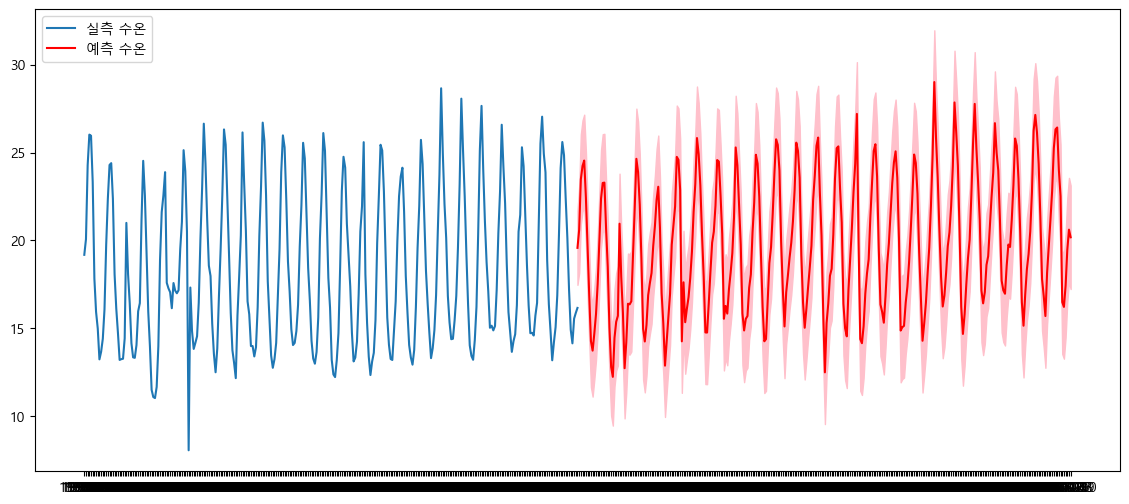

RMSE: 2.2761731928403046


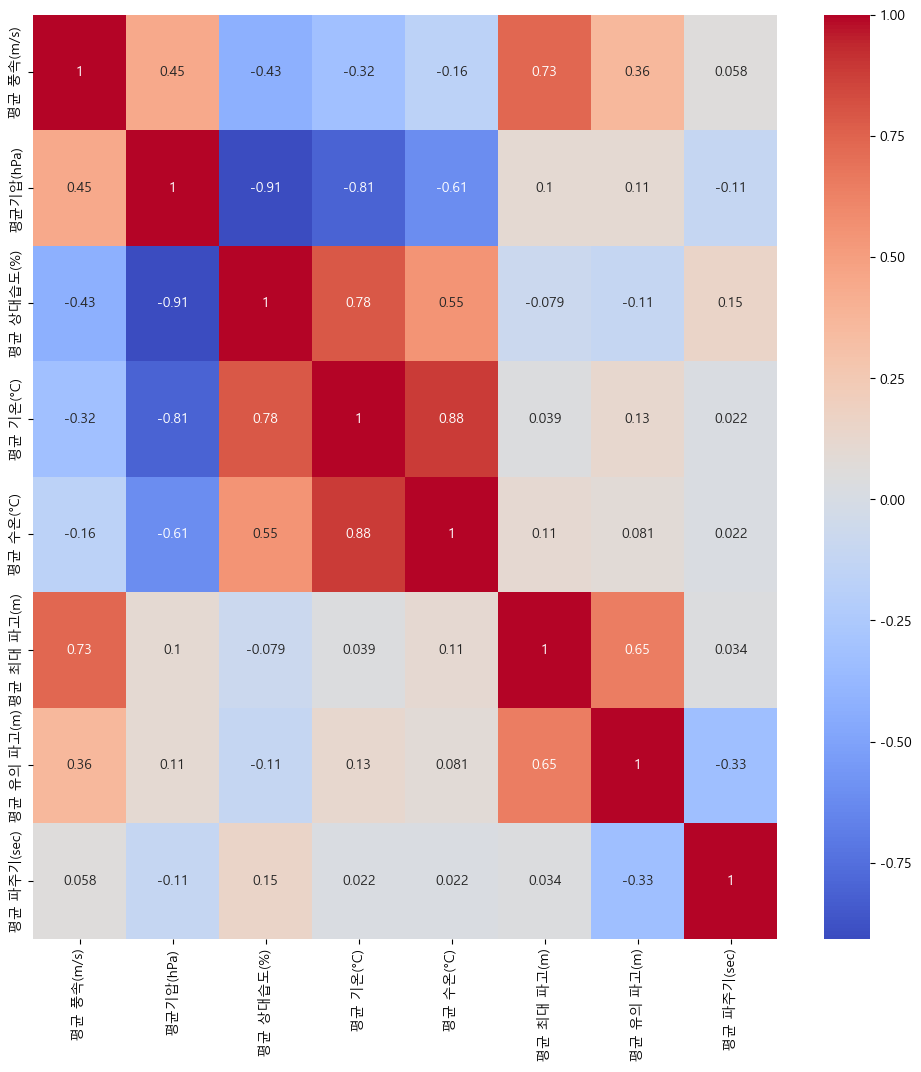

In [5]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
data=data.set_index('일시') # 일시를 인덱스로
data.index = pd.to_datetime(data.index)
# 월 평균 계산
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('M').mean()
data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환

data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m')

data = data.reset_index()  # 인덱스를 열로 변환
data = data.set_index('일시')  # 다시 인덱스로 설정
# print('결과 비교',data['평균 기온(°C)'])

# 평균기온 증가시킬 크기 설정(25년 * 12월 * 1달마다 증가시킬 값)
# step = 0.01397179185721 * 25 * 12
step = 0.01397179185721

data = data.reset_index()

# 값 증가
data['평균 기온(°C)'] += step * data.index

# '일시' 열을 datetime 형식으로 변환
data['일시'] = pd.to_datetime(data['일시'])

# 년도를 25년씩 증가시킴
data['일시'] = data['일시'] + pd.DateOffset(years=25)

# 날짜를 'YYYY-MM' 형식으로 변환
data['일시'] = data['일시'].dt.strftime('%Y-%m')
data = data.set_index('일시')  # 다시 인덱스로 설정
# 결과 확인
# print('결과 확인',data['평균 기온(°C)'])

dataoriginal = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
dataoriginal=dataoriginal.set_index('일시') # 일시를 인덱스로
dataoriginal.index = pd.to_datetime(dataoriginal.index)
# 월 평균 계산
dataoriginal = dataoriginal[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('M').mean()
dataoriginal = dataoriginal.sort_values('일시', ascending=True)
dataoriginal.loc[dataoriginal['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
dataoriginal=dataoriginal.dropna()

dataoriginal = dataoriginal.reset_index()  # 인덱스를 열로 변환

dataoriginal = dataoriginal.set_index('일시')  # 다시 인덱스로 설정
dataoriginal.index = pd.to_datetime(dataoriginal.index).strftime('%Y-%m')

dataoriginal = dataoriginal.reset_index()  # 인덱스를 열로 변환
dataoriginal = dataoriginal.set_index('일시')  # 다시 인덱스로 설정
# print('dataoriginal',dataoriginal['평균 기온(°C)'])

# exog를 다시 정의합니다.
exogoriginal = dataoriginal[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
# print('exog:',exog)

# 시계열 모델을 학습합니다.
model = SARIMAX(dataoriginal['평균 수온(°C)'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 12), exog=exogoriginal)
results = model.fit(disp=False)


forecast_steps = len(dataoriginal)
forecast = results.get_forecast(steps=forecast_steps, exog=exog)
# print('exogoriginal:',exogoriginal)
# print('exog:',exog)
forecast_conf_int = forecast.conf_int()

forecast_index = pd.period_range(start='2023-05-19', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환

forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(dataoriginal.index, dataoriginal['평균 수온(°C)'], label='실측 수온')
# 예측 만들기, 범위 지정
plt.plot(forecast_index.strftime('%Y-%m'), forecast.predicted_mean, label='예측 수온', color='r')
plt.fill_between(forecast_index.strftime('%Y-%m'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

# print(data.index)
# print(forecast_index.strftime('%Y-%m'))
# print(forecast.predicted_mean.shape)

# print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['평균 수온(°C)'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

In [6]:
import pymysql
from sqlalchemy import create_engine, types
# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'geojeforecast'

# 인덱스 복구
dataoriginal = dataoriginal.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()

# 인덱스 열 삭제
forecast.predicted_mean = forecast.predicted_mean.reset_index()
forecast.predicted_mean = forecast.predicted_mean.drop('index', axis=1)
# 인덱스 열 새로 추가
forecast.predicted_mean.index = forecast_index
forecast.predicted_mean = forecast.predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [dataoriginal, forecast_conf_int, forecast.predicted_mean]  # 첫 번째 요소들의 리스트
list2 = ['dataoriginal', 'dataforecastconf', 'dataforecast']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.VARCHAR(45), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()

c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


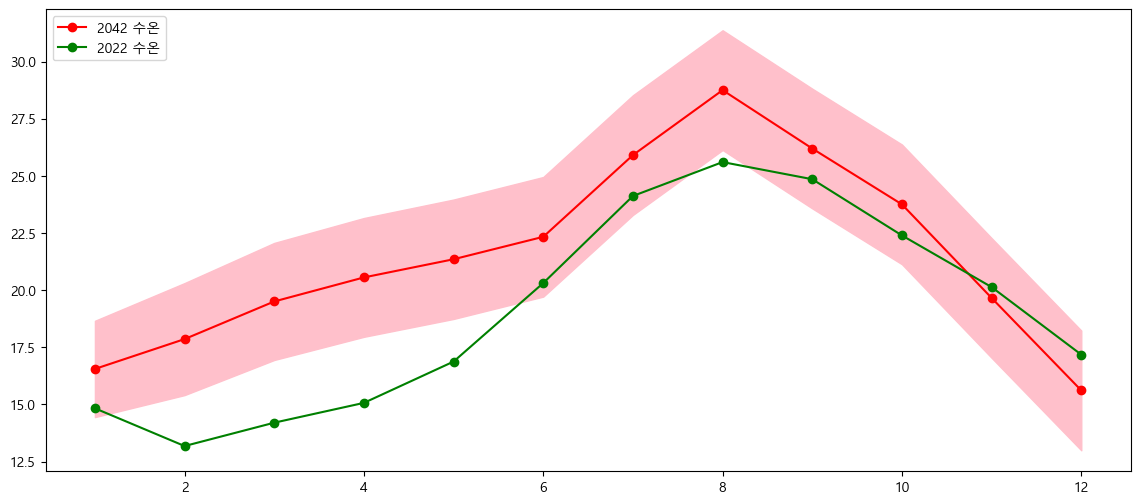

RMSE: 2.954262324463937


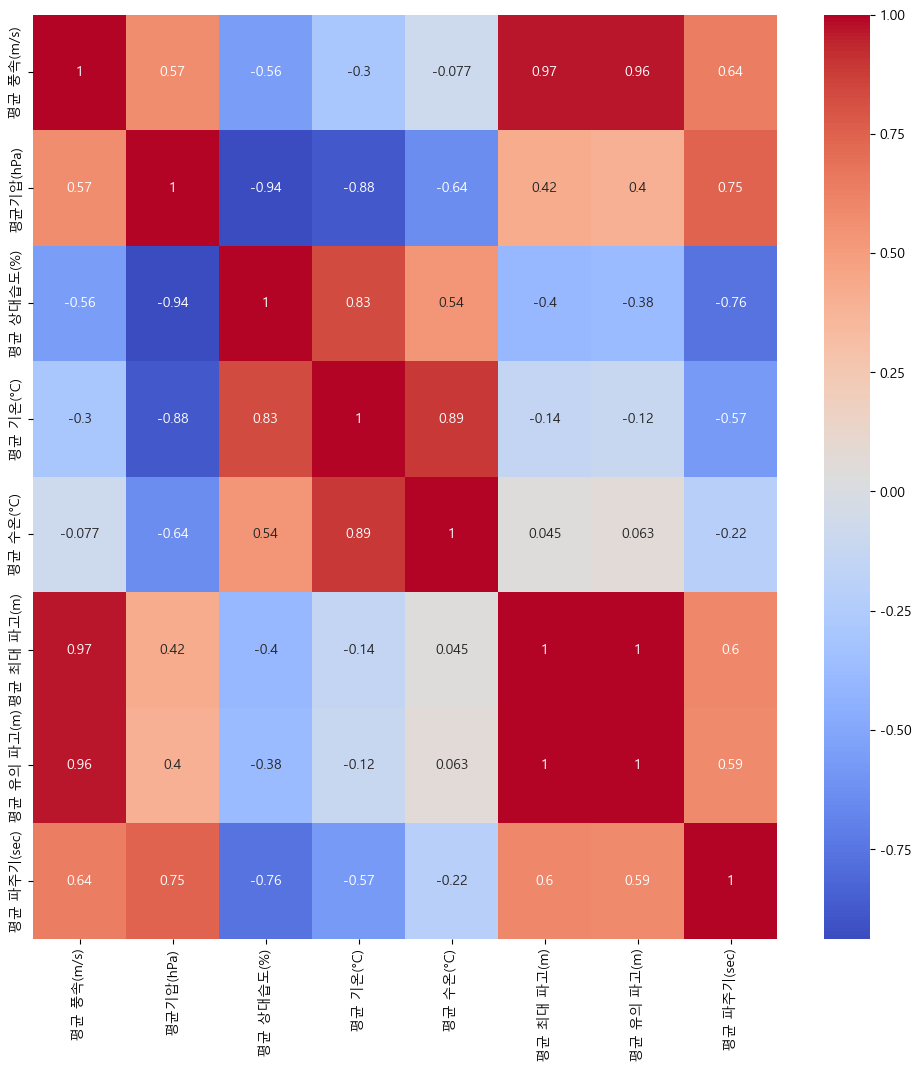

In [7]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
data=data.set_index('일시') # 일시를 인덱스로
data.index = pd.to_datetime(data.index)
# 월 평균 계산
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('M').mean()
data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환

data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m')

# 데이터프레임 열 합치기
# data = pd.concat([data, data1], axis=1)
data = data.reset_index()  # 인덱스를 열로 변환
data = data.set_index('일시')  # 다시 인덱스로 설정
# print('결과 비교',data['평균 기온(°C)'])

# 평균기온 증가시킬 크기 설정(20년 * 12월 * 1달마다 증가시킬 값)
step = 0.01397179185721 * 20 * 12
# 값 증가
data['평균 기온(°C)'] += step

data = data.reset_index()

# '일시' 열을 datetime 형식으로 변환
data['일시'] = pd.to_datetime(data['일시'])

# 년도를 25년씩 증가시킴
data['일시'] = data['일시'] + pd.DateOffset(years=25)

# 날짜를 'YYYY-MM' 형식으로 변환
data['일시'] = data['일시'].dt.strftime('%Y-%m')
data = data.set_index('일시')  # 다시 인덱스로 설정

# 결과 확인
# print('결과 확인',data['평균 기온(°C)'])

# 위쪽 비교용 데이터 만들기, 아래 오리지널 데이터 만들기.
dataoriginal = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
dataoriginal=dataoriginal.set_index('일시') # 일시를 인덱스로
dataoriginal.index = pd.to_datetime(dataoriginal.index)
# 월 평균 계산
dataoriginal = dataoriginal[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('M').mean()
dataoriginal = dataoriginal.sort_values('일시', ascending=True)
dataoriginal.loc[dataoriginal['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
dataoriginal=dataoriginal.dropna()

dataoriginal = dataoriginal.reset_index()  # 인덱스를 열로 변환

dataoriginal = dataoriginal.set_index('일시')  # 다시 인덱스로 설정
dataoriginal.index = pd.to_datetime(dataoriginal.index).strftime('%Y-%m')

dataoriginal = dataoriginal.reset_index()  # 인덱스를 열로 변환
dataoriginal = dataoriginal.set_index('일시')  # 다시 인덱스로 설정
# print('dataoriginal',dataoriginal['평균 기온(°C)'])

# exog를 다시 정의합니다.
exogoriginal = dataoriginal[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
# print('exog:',exog)

# 시계열 모델을 학습합니다.
model = SARIMAX(dataoriginal['평균 수온(°C)'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 12), exog=exogoriginal)
results = model.fit(disp=False)

# 특정 기간의 'start_date'과 'end_date' 열 선택
start_date = '2042-01'
end_date = '2042-12'
data = data.loc[start_date:end_date]
# print('data2:',data)

# 예측 기간을 설정합니다.
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps, exog=exog.loc[start_date:end_date])
# print('exogoriginal:',exogoriginal)
# print('exog:',exog)

# 2022년의 'start_date'과 'end_date' 열 선택
start_date = '2022-01'
end_date = '2022-12'
dataoriginal = dataoriginal.loc[start_date:end_date]
# print('data2:',data)

# 예측 결과와 신뢰 구간을 얻습니다.
forecast_conf_int = forecast.conf_int()

forecast_index = pd.period_range(start='2044-01-19', periods=forecast_steps, freq='M')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환

forecast.predicted_mean.index = forecast_index.strftime('%Y-%m')
forecast_conf_int.index = forecast_index

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

# 데이터프레임 생성
date = pd.DataFrame({'date': [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10, 11, 12]})

plt.figure(figsize=(14, 6))
plt.plot(date['date'], forecast.predicted_mean, label='2042 수온', color='r', marker='o', linestyle='-')
plt.plot(date['date'], dataoriginal['평균 수온(°C)'], label='2022 수온', color='g', marker='o', linestyle='-')
plt.fill_between(date['date'], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

# print(data.index)
# print(forecast_index.strftime('%Y-%m'))
# print(forecast.predicted_mean)

# print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['평균 수온(°C)'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

In [8]:
import pymysql
from sqlalchemy import create_engine, types
# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'geojeforecast'

# 인덱스 복구
dataoriginal = dataoriginal.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()

# 인덱스 열 삭제
forecast.predicted_mean = forecast.predicted_mean.reset_index()
forecast.predicted_mean = forecast.predicted_mean.drop('index', axis=1)
# 인덱스 열 새로 추가
forecast.predicted_mean.index = forecast_index
forecast.predicted_mean = forecast.predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [dataoriginal, forecast_conf_int, forecast.predicted_mean]  # 첫 번째 요소들의 리스트
list2 = ['datacompare2022', 'datacompareforecast2042conf', 'datacompareforecast2042']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.VARCHAR(45), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()